In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

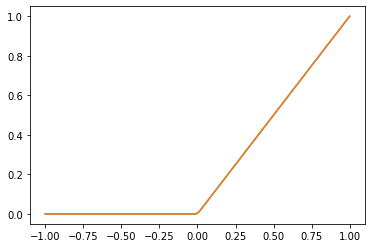

In [2]:
from tomopt.core import *
import torch
from torch import Tensor
from torch.nn import functional as F

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from torch import nn
from tomopt.volume import PassiveLayer, PanelDetectorLayer, DetectorPanel, DetectorHeatMap

from tomopt.volume import Volume
from functools import partial
from tomopt.optimisation import PanelVolumeWrapper, VoxelX0Loss, HeatMapVolumeWrapper
from tomopt.core import X0
from tomopt.optimisation import PassiveYielder
from tomopt.optimisation import NoMoreNaNs, PanelMetricLogger, CostCoefWarmup
from tomopt.plotting import plot_pred_true_x0

DEVICE = torch.device('cpu')
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)
#     return (F.relu(x) / 0.7) ** 2

x = torch.linspace(-1, 1, 100)
plt.plot(x, area_cost(x))
plt.plot(x, F.relu(x))

# def arb_rad_length(*, z:float, lw:Tensor, size:float) -> Tensor:
#     rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
#     if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
#     return rad_length

def arb_rad_length(*, z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    if z >= 0.6 and z <= 0.7: rad_length[:4,:4] = X0['lead']
    return rad_length

In [3]:
def get_layers():
    layers = []
    lwh = Tensor([1, 1, 1])
    size = 0.1
    init_eff = 1.0
    init_res = 1000
    n_panels = 4
    
    
    # set detectors above volume
    panels_up = [
        DetectorHeatMap(
            init_xyz=[0., 0., 1 - (i*(2*size)/n_panels)],
            init_xy_span=[-0.5, 0.5],
            area_cost_func=area_cost,
            device=DEVICE,
            res=init_res,
            eff=init_eff,
            n_cluster=35,
        ) 
        for i in range(n_panels)
    ]
    # set detectors below volume
    panels_down = [
        DetectorHeatMap(
            init_xyz=[0.0, 0.0, 0.2 - (i*(2*size)/n_panels)],
            init_xy_span=[-0.5, 0.5],
            area_cost_func=area_cost,
            device=DEVICE,
            res=init_res,
            eff=init_eff,
            n_cluster=35,
        )
        for i in range(n_panels)
    ]
    
    
    layers.append(
        PanelDetectorLayer(
            pos='above',
            lw=lwh[:2],
            z=1,
            size=2*size,
            panels=panels_up,
        )
    )
    
    # set passive volume
    for z in [0.8, 0.7, 0.6, 0.5, 0.4, 0.3]:
        layers.append(
            PassiveLayer(
                lw=lwh[:2],
                z=z,
                size=size,
                device=DEVICE,
            )
        )
    
    layers.append(
        PanelDetectorLayer(
            pos='below',
            lw=lwh[:2],
            z=0.2,
            size=2*size,
            panels=panels_down,
        )
    )

    return nn.ModuleList(layers) 

In [4]:
volume = Volume(get_layers())
print(volume.get_cost())
wrapper = HeatMapVolumeWrapper(
    volume,
    mu_opt=partial(torch.optim.SGD, lr=1e5),
    norm_opt=partial(torch.optim.SGD, lr=1e5),
    sig_opt=partial(torch.optim.SGD, lr=1e4),
    z_pos_opt=partial(torch.optim.SGD, lr=1e4),
    loss_func=VoxelX0Loss(target_budget=8, cost_coef=None),
) 
# Loss is precision + budget_coef*cost_coef, balance coef as required or leave as None to automatically balance on first batch
passives = PassiveYielder([arb_rad_length])

tensor(2.2988, grad_fn=<AddBackward0>)


/home/max/Software/mode_muon_tomography/tomopt/volume/heatmap.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rand_mu += torch.tensor(self._init_xy)


/home/max/Software/mode_muon_tomography/venv/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/max/Software/mode_muon_tomography/tomopt/volume/heatmap.py:153: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  stacked_t = torch.stack([x, y]).T


<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([ 0.0404, -0.0024], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([1.]).


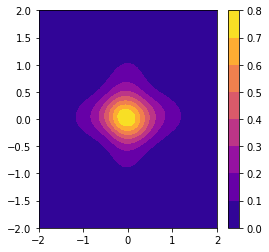

<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([-0.0058, -0.0735], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([0.9500]).


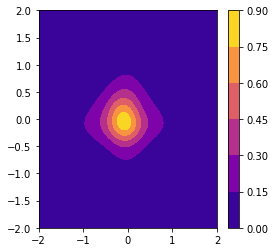

<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([0.0107, 0.0159], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([0.9000]).


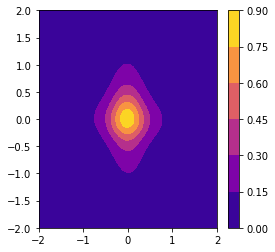

<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([ 0.0016, -0.0050], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([0.8500]).


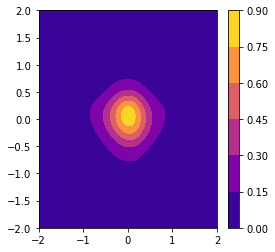

<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([-0.0260, -0.0361], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([0.2000]).


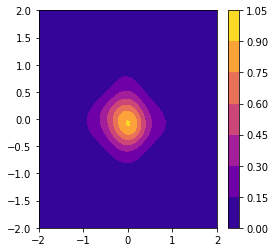

<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([-0.0175, -0.0014], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([0.1500]).


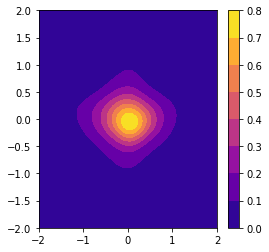

<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([-0.0227, -0.0700], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([0.1000]).


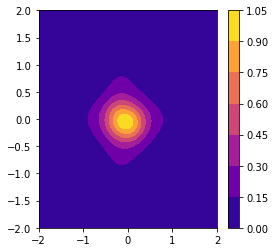

<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([ 0.0140, -0.0126], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([0.0500]).


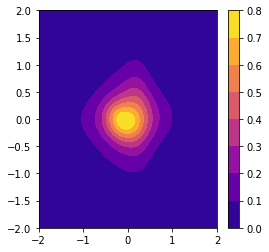

In [5]:
for p in volume:
    if isinstance(p, PanelDetectorLayer):
        for d in p.panels:
            print(d)
            d.plot_map()

CostCoefWarmup: Freezing optimisation for 4 epochs


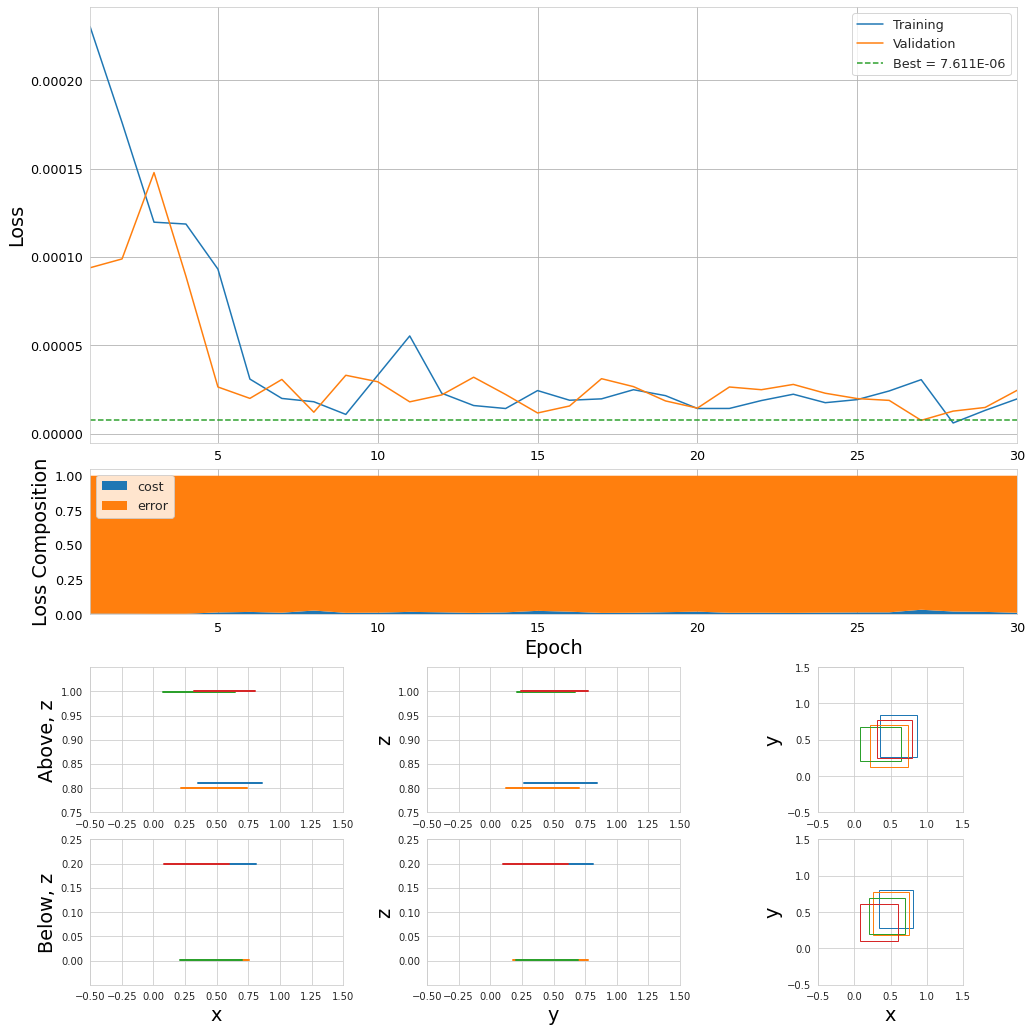

Automatically setting cost coefficient to 0.00022989392164163291


/home/max/Software/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:211: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


CostCoefWarmup: Warmed up, average error = tensor([0.0002])


KeyboardInterrupt: 

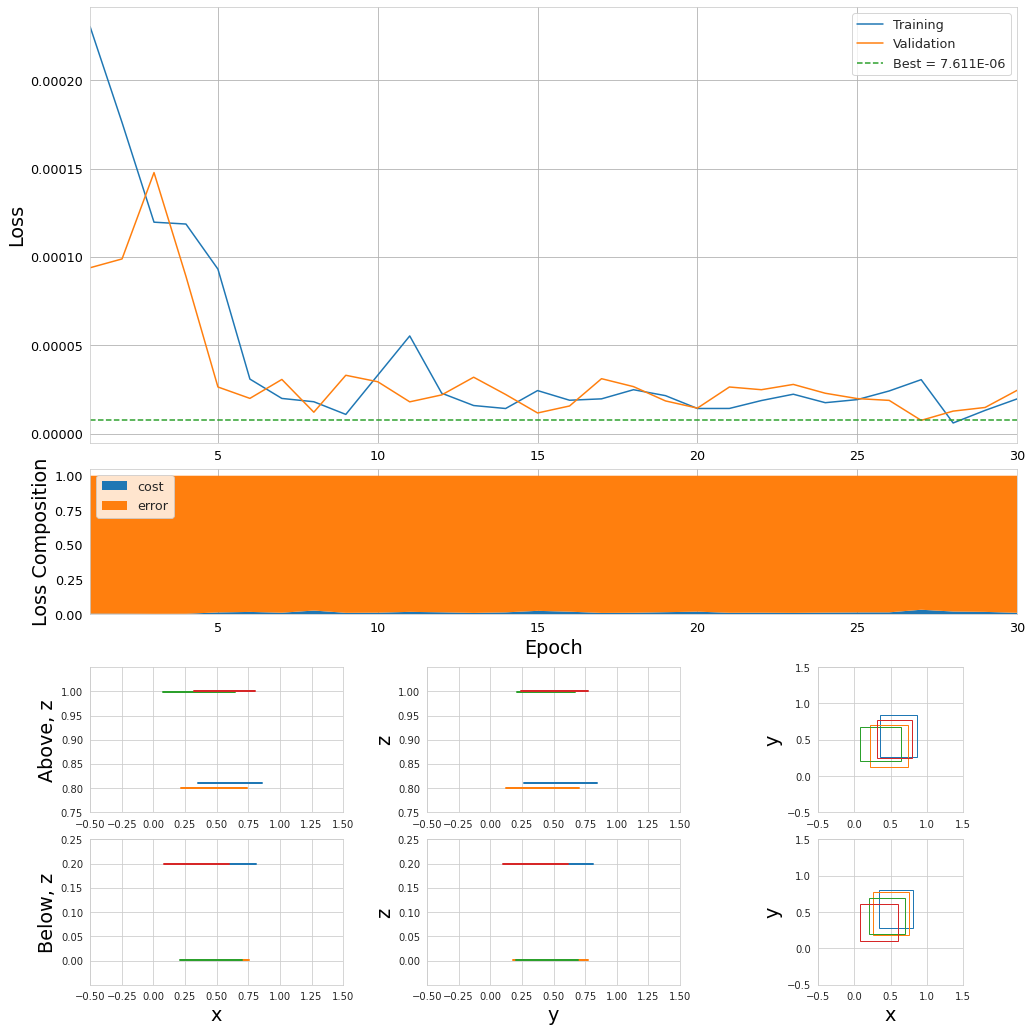

In [6]:
_ = wrapper.fit(
    n_epochs=60,
    passive_bs=1,
    n_mu_per_volume=1200, #1000
    mu_bs=1200, # 1000
    trn_passives=passives,
    val_passives=passives,
    cbs=[CostCoefWarmup(n_warmup=4), NoMoreNaNs(), PanelMetricLogger()],
)
# _ = wrapper.fit(
#     n_epochs=9,
#     passive_bs=1,
#     n_mu_per_volume=700,
#     mu_bs=700,
#     trn_passives=passives,
#     val_passives=passives,
#     cbs=[CostCoefWarmup(n_warmup=2), NoMoreNaNs(), PanelMetricLogger()],
# )

<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([0.5987, 0.5542], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([0.8007]).


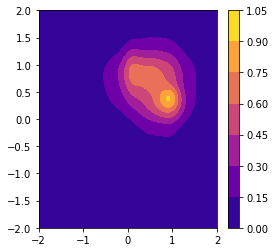

<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([0.4686, 0.4192], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([0.9993]).


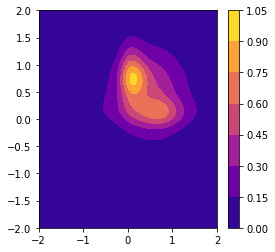

<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([0.3728, 0.4460], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([0.9991]).


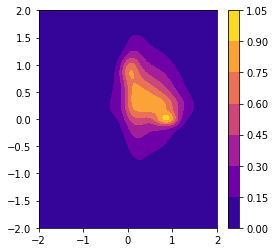

<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([0.5608, 0.5249], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([0.8006]).


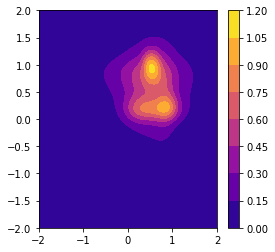

<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([0.5762, 0.5430], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([0.0004]).


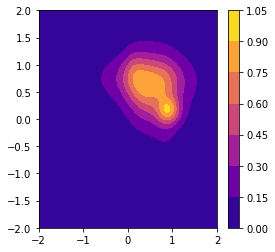

<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([0.5082, 0.4758], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([0.1998]).


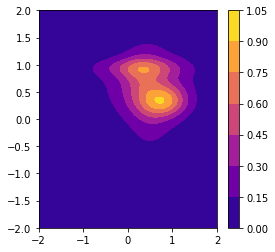

<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([0.4561, 0.4501], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([0.1992]).


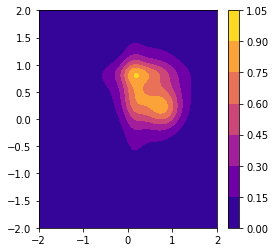

<class 'tomopt.volume.heatmap.DetectorHeatMap'> at av. xy=tensor([0.3413, 0.3552], grad_fn=<MeanBackward1>) with n_comp 35, z=tensor([0.1996]).


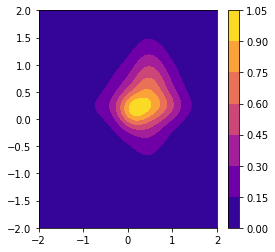

In [7]:
for p in volume:
    if isinstance(p, PanelDetectorLayer):
        for d in p.panels:
            print(d)
            d.plot_map()

In [8]:
preds = wrapper.predict(
    passives,
    n_mu_per_volume=1200, # 1000
    mu_bs=1200,# 1000, 2500
)

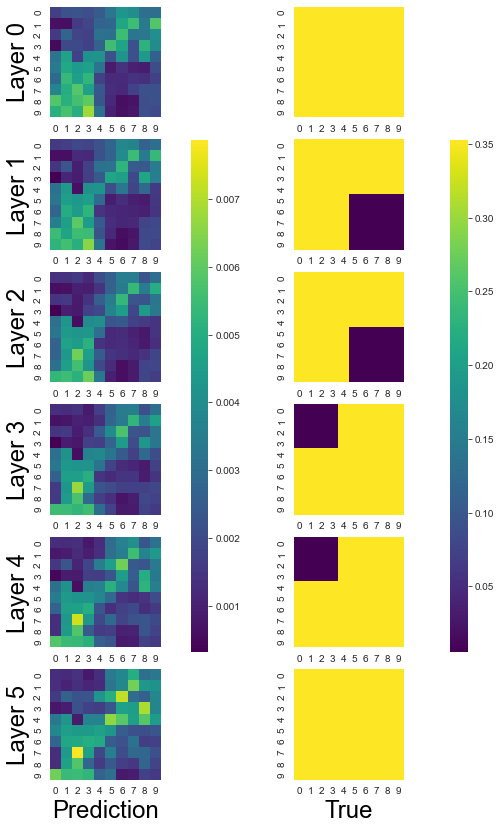

In [9]:
plot_pred_true_x0(*preds[0])